In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature
from skimage.feature import hog
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [146]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### file paths and names

In [147]:
ci_path = 'plane_data/cropped_images/' # file path for cropped images for training
l_file = 'plane_data/plane_labels.csv' # file path and file name for csv with labels

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [170]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (30, 70) # 25% of the original size, 525 pixels

downscaled image shape: 
(30, 70)
image representation (first row of pixels): 
[ 3.36627976e-03  2.46561172e-03 -1.67623204e-04 -2.46218585e-04
 -3.10213966e-04 -3.56215984e-04 -4.30370351e-04 -6.19604457e-04
  2.34639816e-04  3.54371499e-04  4.58965508e-05 -1.30768144e-04
 -2.12265665e-04 -2.61991622e-04 -2.70992604e-04 -2.33971219e-04
 -2.11699944e-04 -1.91639431e-04 -1.94576890e-04 -2.26136373e-04
 -2.70111841e-04 -2.61190636e-04 -1.49404675e-04 -2.36435468e-04
 -4.59801121e-04 -6.91947389e-04 -6.21364311e-04 -7.84647720e-05
 -5.85264040e-04 -5.55037378e-04 -8.33997229e-04 -8.03176392e-04
 -7.72856707e-04 -1.18838225e-03 -1.30092467e-03 -3.24246998e-04
  5.86285646e-04 -1.15651517e-04 -3.36440754e-04 -5.16957304e-04
 -6.59973165e-04 -2.95396129e-04  5.74908609e-04  4.88815480e-04
  7.73736927e-05 -9.60152058e-05 -1.27989525e-04 -1.65334288e-04
 -1.79321583e-04 -1.08250915e-04 -7.92228859e-05 -8.96969755e-05
 -1.14656547e-04 -1.00501055e-04 -5.99402513e-05 -1.52606182e-04
 -1.8908035

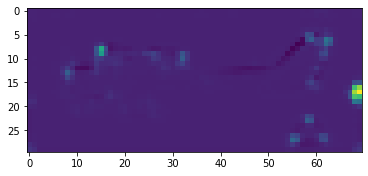

In [171]:
# def image_manipulation(imname, imgs_path, imview=False):
#     warnings.filterwarnings('ignore')
#     imname = imgs_path + imname + '.png'
#     img_raw = io.imread(imname)
    
#     downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
#     gray =color.rgb2gray(downscaled)
# #     pie = img_as_bool(gray)
#     final_image = feature.canny(gray, sigma = 0.01, low_threshold = 0.01) # edge filter image with Canny algorithm
#     if imview==True:
#         io.imshow(final_image)
#     warnings.filterwarnings('always')
#     return final_image

# # test the function, look at input/output
# test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
# print('downscaled image shape: ')
# print(test_image.shape)
# print('image representation (first row of pixels): ')
# print(test_image[0])
# print('\n')
# print('example of transformation: ')


def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image

    final_image = feature.corner_harris(downscaled, k=0.01, eps=1000, sigma=0.5)

    if imview==True:
        plt.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

for comparison, look at original image:

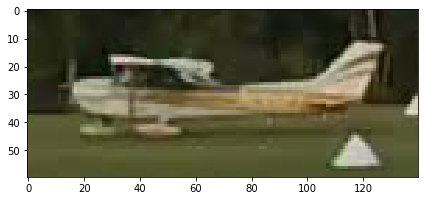

In [172]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

# function to process raw images, resulting in training and test datasets

In [173]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [174]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=13, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 30, 70)
Shape of flat feature representation: 
(6758, 2100)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
80
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
21
Shape of data_train and data_test:
(5068, 2100)
(1690, 2100)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


# train Perceptron

In [192]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', alpha=0.00000001, max_iter=100000)
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 75, 'TN': 4987, 'FP': 1, 'FN': 5, 'Accuracy': 0.9988161010260458, 'Precision': 0.9868421052631579, 'Recall': 0.9375, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 14, 'TN': 1661, 'FP': 8, 'FN': 7, 'Accuracy': 0.9911242603550295, 'Precision': 0.6363636363636364, 'Recall': 0.6666666666666666, 'desc': 'prc', 'set': 'test'}


In [193]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

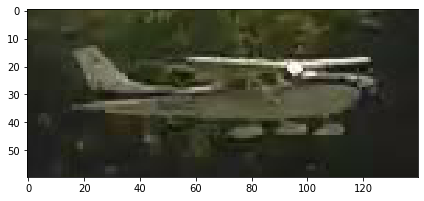

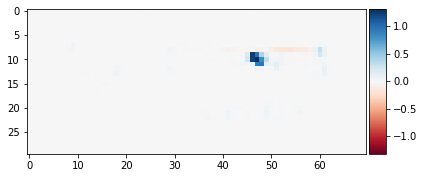

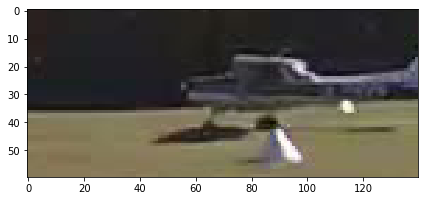

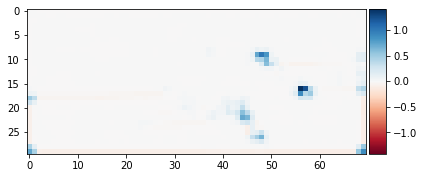

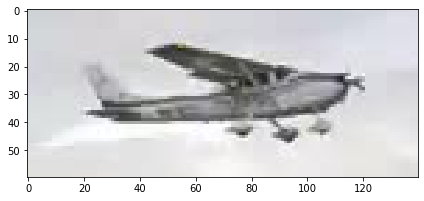

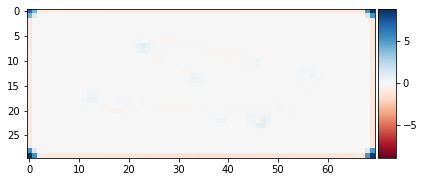

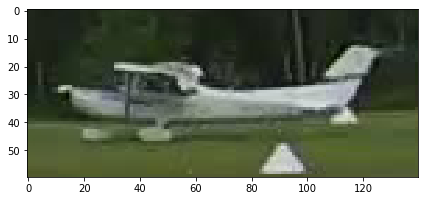

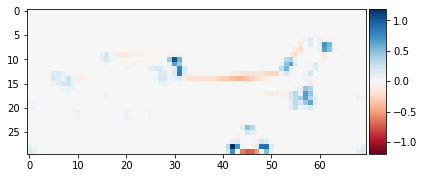

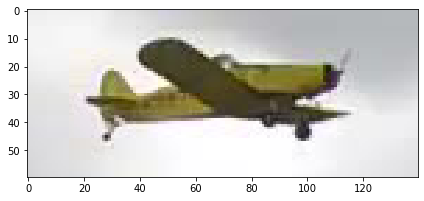

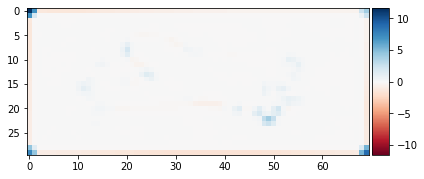

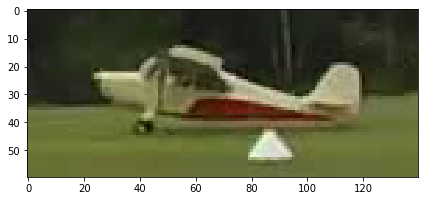

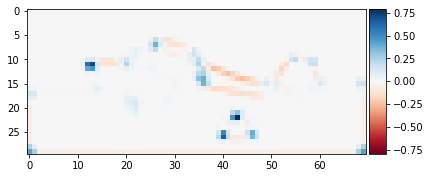

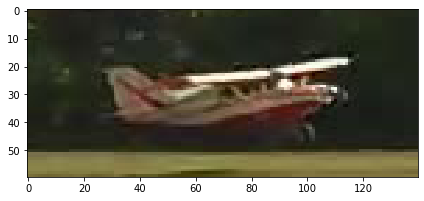

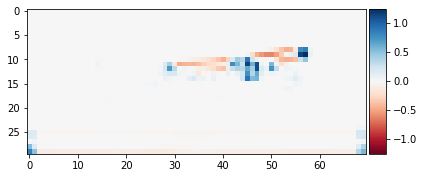

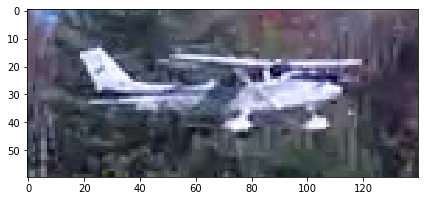

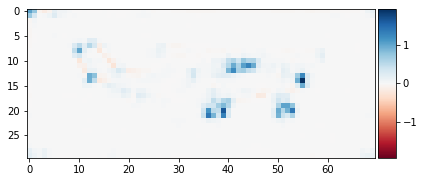

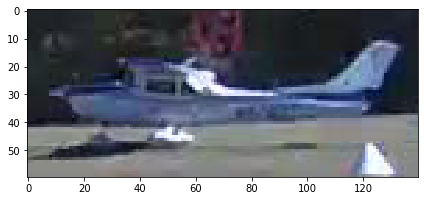

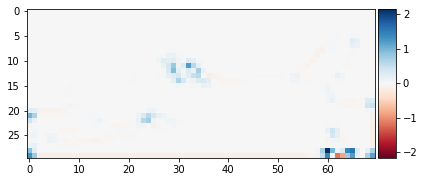

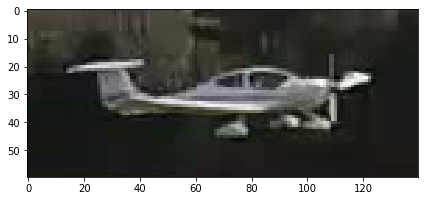

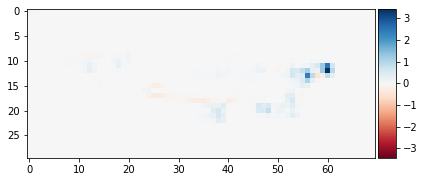

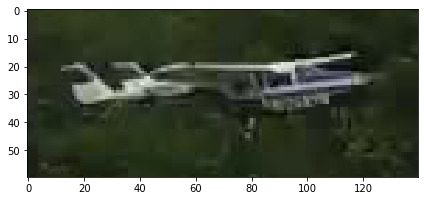

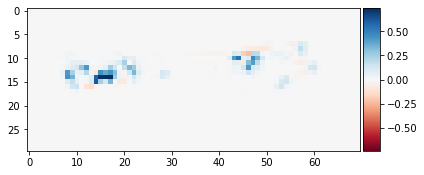

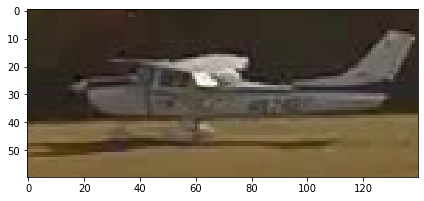

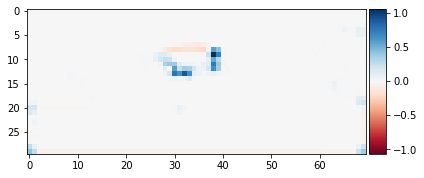

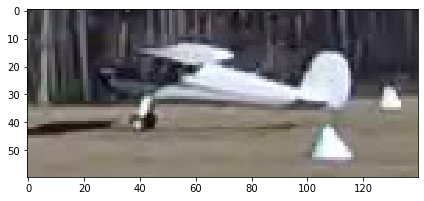

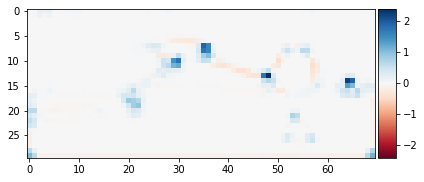

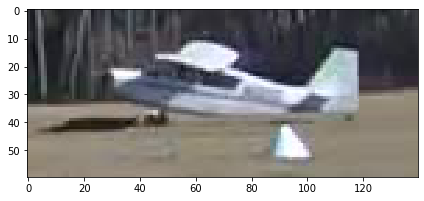

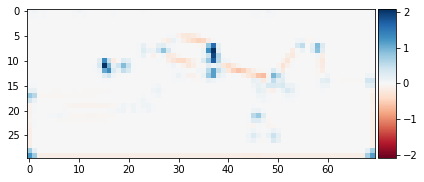

In [194]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

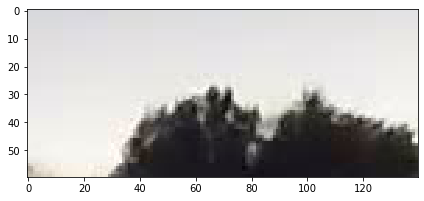

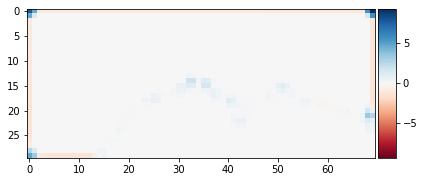

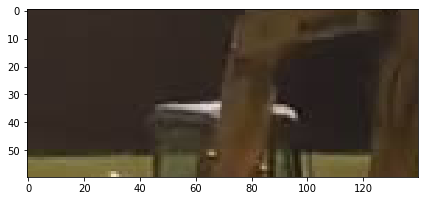

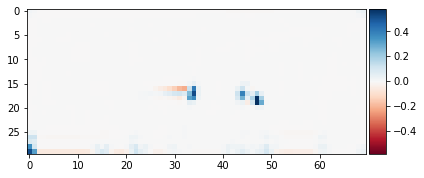

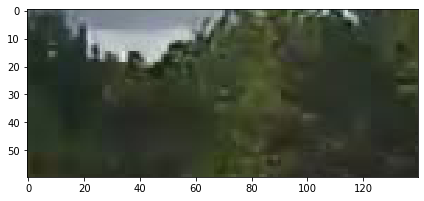

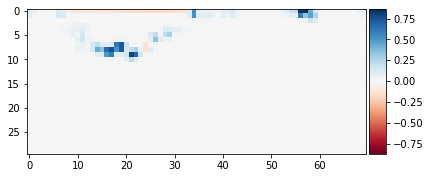

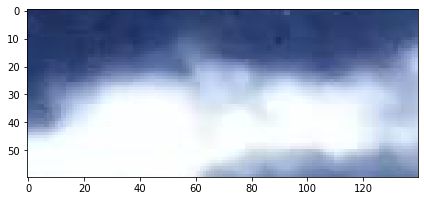

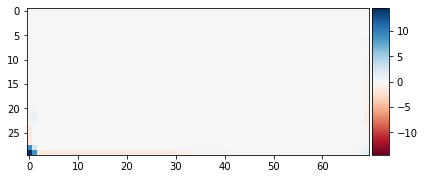

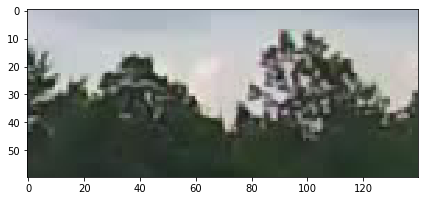

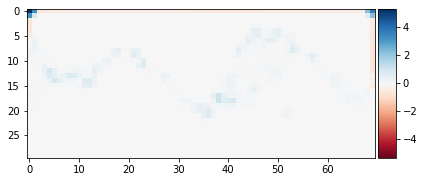

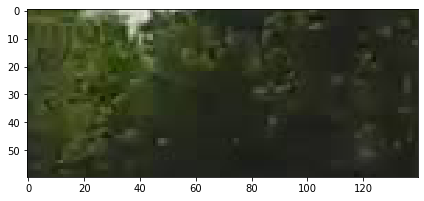

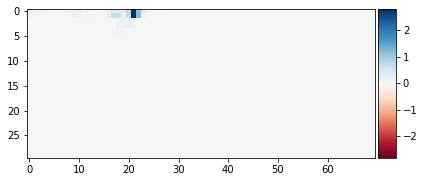

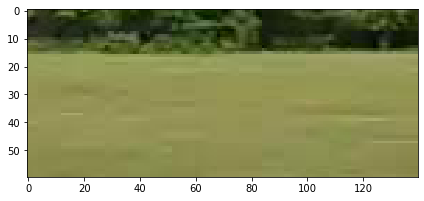

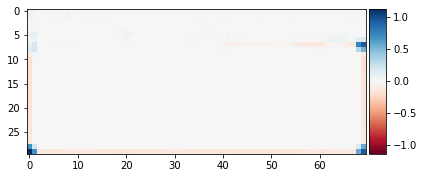

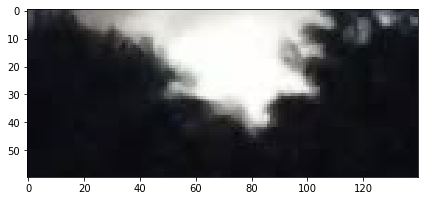

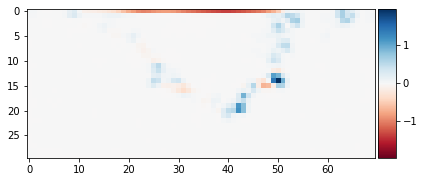

In [195]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

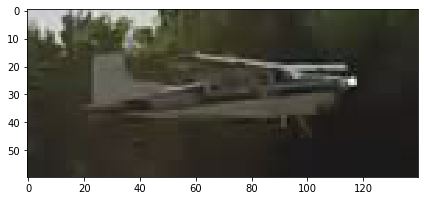

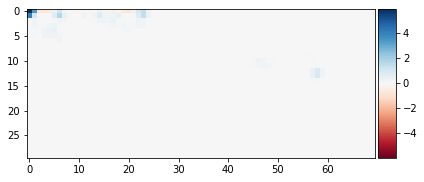

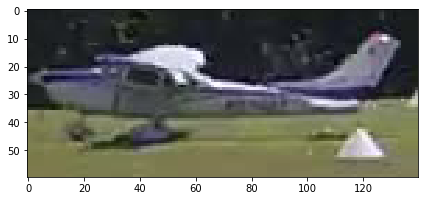

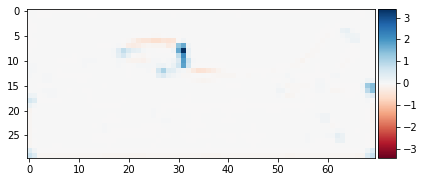

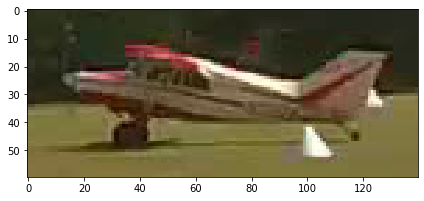

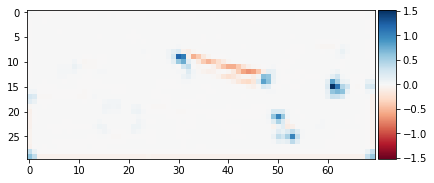

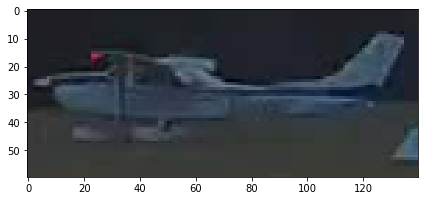

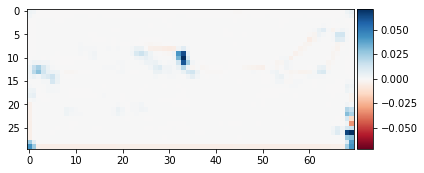

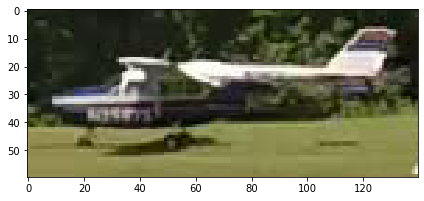

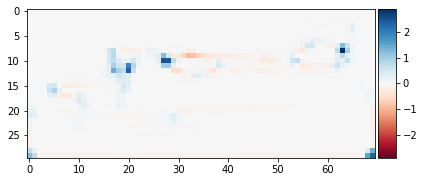

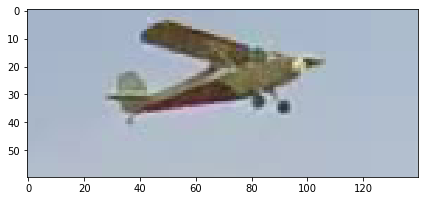

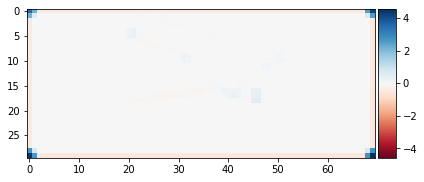

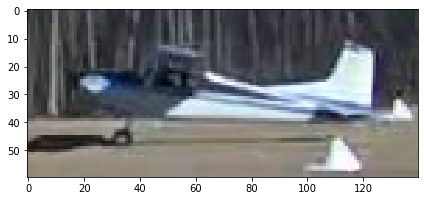

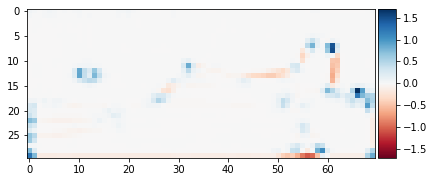

In [196]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [197]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes = (100, 100, 100, 100), alpha=0.000001, max_iter=10000000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

# version 2
nn2 = neural_network.MLPClassifier(hidden_layer_sizes = (100, 100, 100, 100, 100), alpha=0.000001,max_iter=10000000)
print(nn2)
nn2.fit(data_train, y_train)

nn2_performance = BinaryClassificationPerformance(nn2.predict(data_train), y_train, 'nn2')
nn2_performance.compute_measures()
nn2_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn2_performance.performance_measures)

nn2_performance_test = BinaryClassificationPerformance(nn2.predict(data_test), y_test, 'nn2_test')
nn2_performance_test.compute_measures()
nn2_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn2_performance_test.performance_measures)

nn2_performance_test.img_indices()
nn2_img_indices_to_view = nn2_performance_test.image_indices

# version 2
nn22 = neural_network.MLPClassifier(hidden_layer_sizes = (100, 100, 100, 100, 100), alpha=0.000001,max_iter=10000000)
print(nn22)
nn22.fit(data_train, y_train)

nn22_performance = BinaryClassificationPerformance(nn22.predict(data_train), y_train, 'nn22')
nn22_performance.compute_measures()
nn22_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn22_performance.performance_measures)

nn22_performance_test = BinaryClassificationPerformance(nn22.predict(data_test), y_test, 'nn22_test')
nn22_performance_test.compute_measures()
nn22_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn22_performance_test.performance_measures)

nn22_performance_test.img_indices()
nn22_img_indices_to_view = nn22_performance_test.image_indices

# version 3
nn3 = neural_network.MLPClassifier(hidden_layer_sizes = (100, 100, 100, 100, 50, 25, 10), alpha=0.000001, max_iter=10000000)
print(nn3)
nn3.fit(data_train, y_train)

nn3_performance = BinaryClassificationPerformance(nn3.predict(data_train), y_train, 'nn3')
nn3_performance.compute_measures()
nn3_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn3_performance.performance_measures)

nn3_performance_test = BinaryClassificationPerformance(nn3.predict(data_test), y_test, 'nn3_test')
nn3_performance_test.compute_measures()
nn3_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn3_performance_test.performance_measures)

nn3_performance_test.img_indices()
nn3_img_indices_to_view = nn3_performance_test.image_indices

# version 4
nn4 = neural_network.MLPClassifier(hidden_layer_sizes = (100, 30, 50), alpha=0.000001, max_iter=10000000)
print(nn4)
nn4.fit(data_train, y_train)

nn4_performance = BinaryClassificationPerformance(nn4.predict(data_train), y_train, 'nn4')
nn4_performance.compute_measures()
nn4_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn4_performance.performance_measures)

nn4_performance_test = BinaryClassificationPerformance(nn4.predict(data_test), y_test, 'nn4_test')
nn4_performance_test.compute_measures()
nn4_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn4_performance_test.performance_measures)

nn4_performance_test.img_indices()
nn4_img_indices_to_view = nn4_performance_test.image_indices

print("*******")
# version 5
nn5 = neural_network.MLPClassifier(hidden_layer_sizes = (50, 30, 100), alpha=0.000001, max_iter=10000000)
print(nn5)
nn5.fit(data_train, y_train)

nn5_performance = BinaryClassificationPerformance(nn5.predict(data_train), y_train, 'nn5')
nn5_performance.compute_measures()
nn5_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn5_performance.performance_measures)

nn5_performance_test = BinaryClassificationPerformance(nn5.predict(data_test), y_test, 'nn5_test')
nn5_performance_test.compute_measures()
nn5_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn5_performance_test.performance_measures)

nn5_performance_test.img_indices()
nn5_img_indices_to_view = nn5_performance_test.image_indices

MLPClassifier(alpha=1e-06, hidden_layer_sizes=(100, 100, 100, 100),
              max_iter=10000000)
TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 15, 'TN': 1663, 'FP': 6, 'FN': 6, 'Accuracy': 0.9928994082840237, 'Precision': 0.7142857142857143, 'Recall': 0.7142857142857143, 'desc': 'nn_test', 'set': 'test'}
MLPClassifier(alpha=1e-06, hidden_layer_sizes=(100, 100, 100, 100, 100),
              max_iter=10000000)
TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn2', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 15, 'TN': 1664, 'FP': 5, 'FN': 6, 'Accuracy': 0.993491124260355, 'Precision': 0.75, 'Recall': 0.7142857142857143, 'desc': 'nn2_test', 'set': 'test'}
MLPClassifier(alpha=1e-06, hidden_layer_sizes=(100, 100, 100, 100, 100),
   

In [198]:
# list of fits to compare: 
final_fits = []
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)
final_fits.append(nn2_performance.performance_measures)
final_fits.append(nn2_performance_test.performance_measures)
final_fits.append(nn22_performance.performance_measures)
final_fits.append(nn22_performance_test.performance_measures)
final_fits.append(nn3_performance.performance_measures)
final_fits.append(nn3_performance_test.performance_measures)
final_fits.append(nn4_performance.performance_measures)
final_fits.append(nn4_performance_test.performance_measures)
final_fits.append(nn5_performance.performance_measures)
final_fits.append(nn5_performance_test.performance_measures)

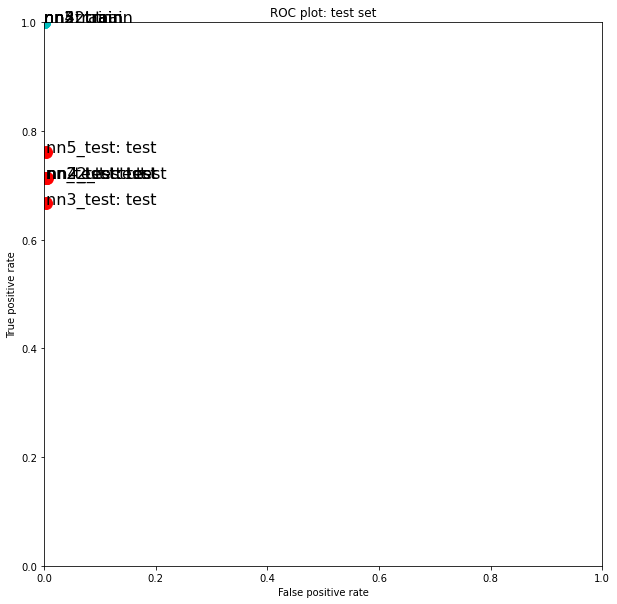

In [199]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# look at examples of neural network classifications

## true positives

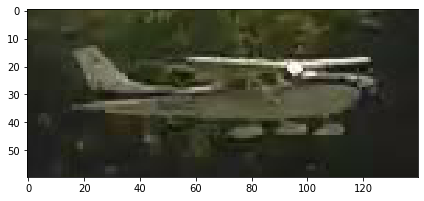

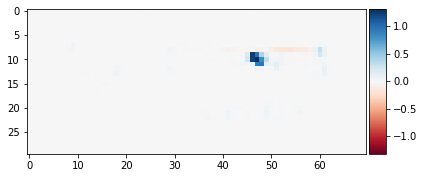

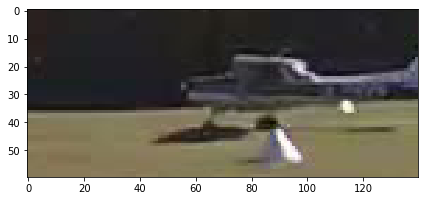

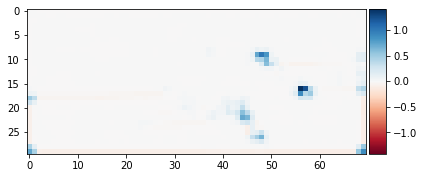

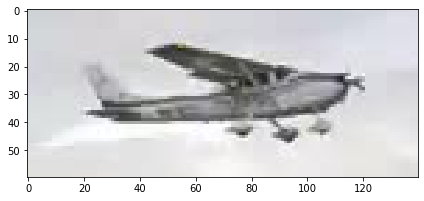

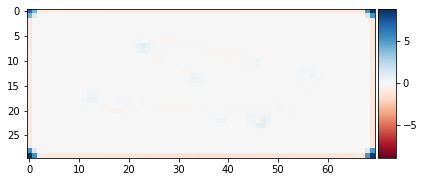

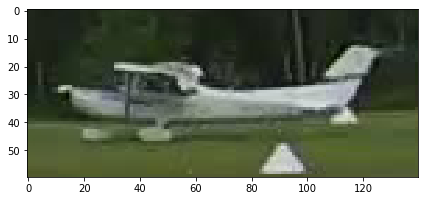

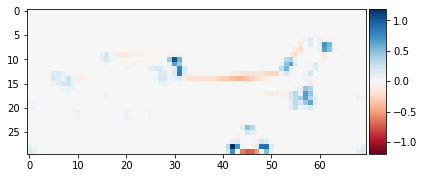

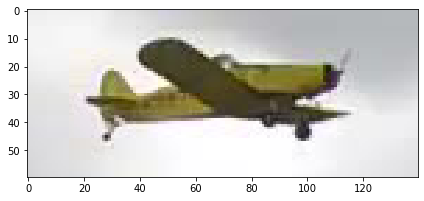

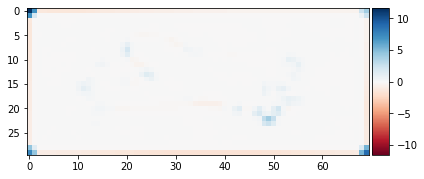

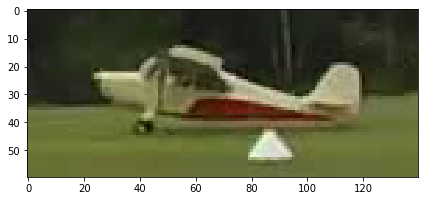

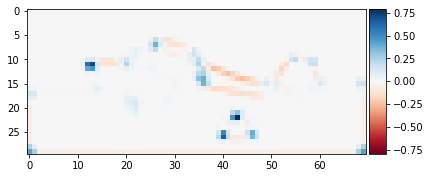

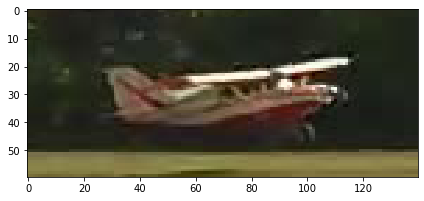

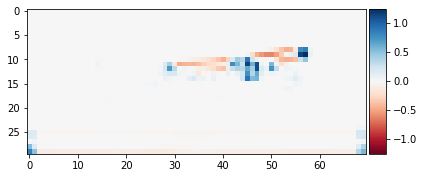

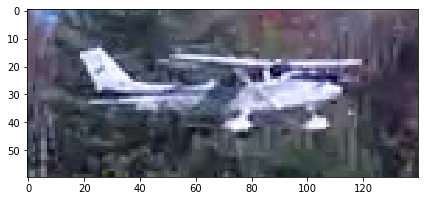

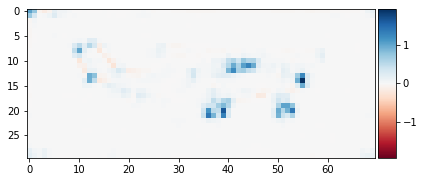

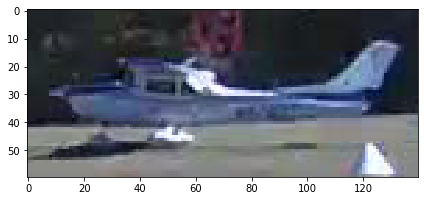

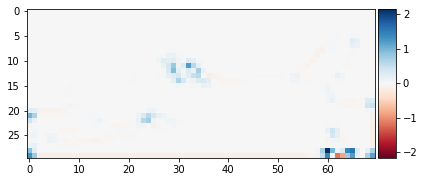

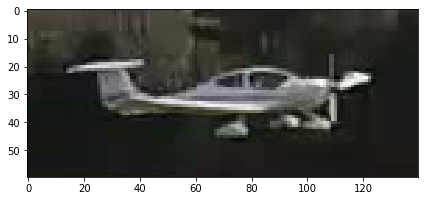

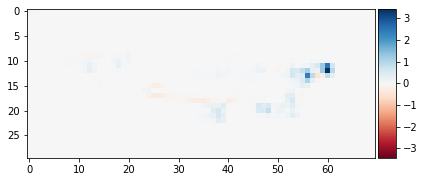

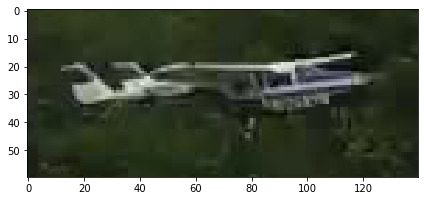

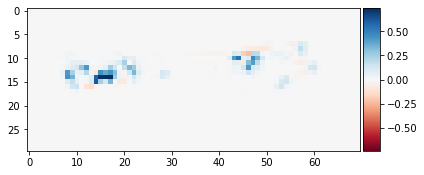

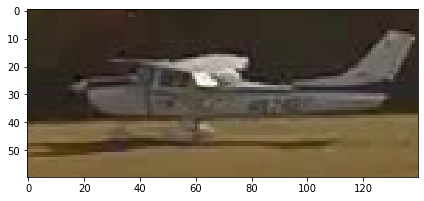

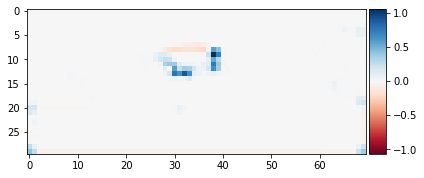

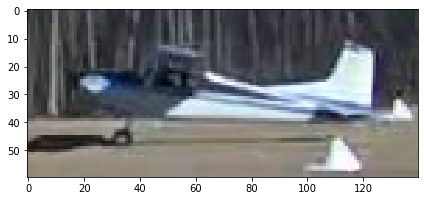

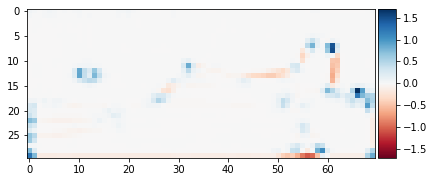

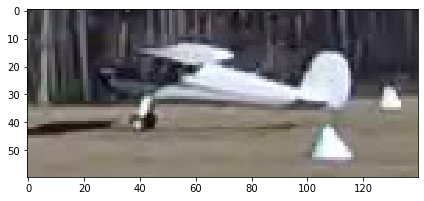

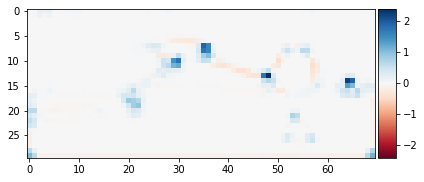

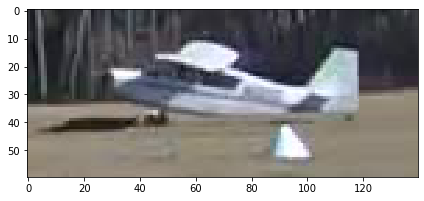

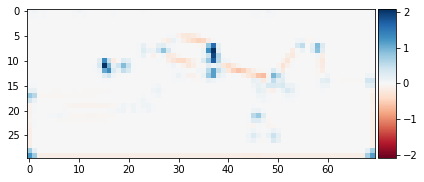

In [200]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

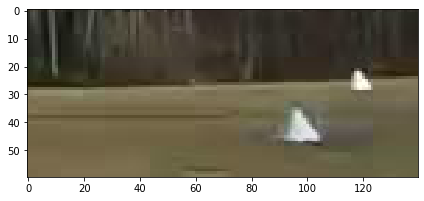

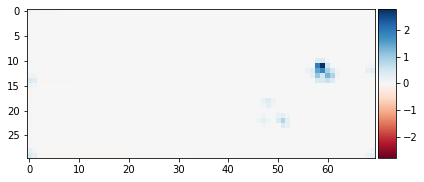

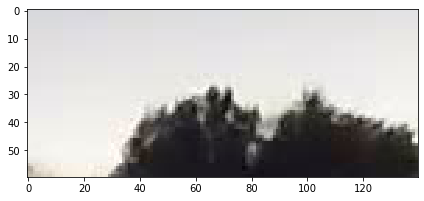

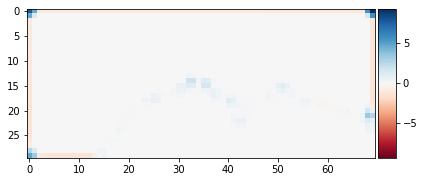

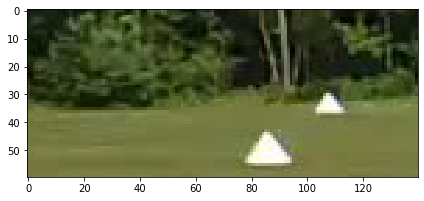

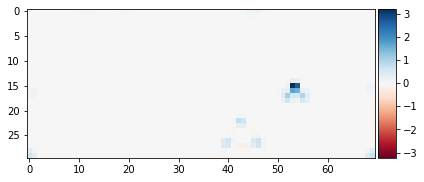

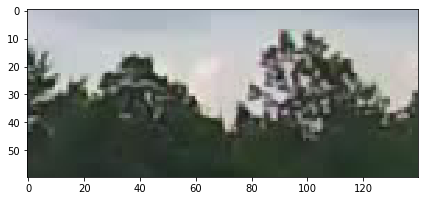

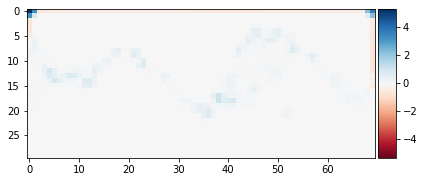

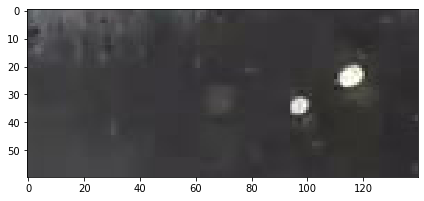

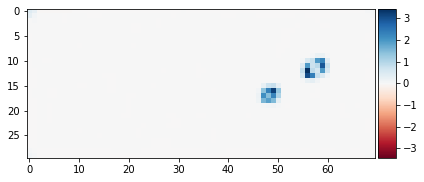

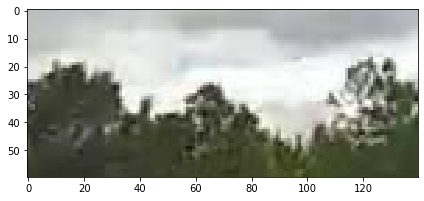

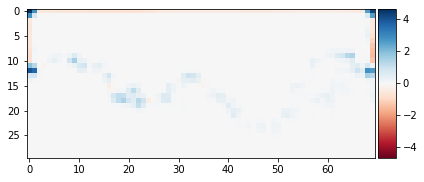

In [201]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

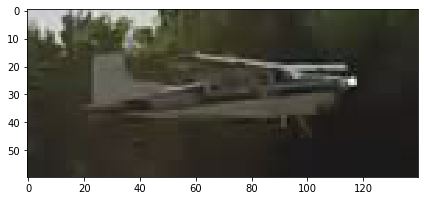

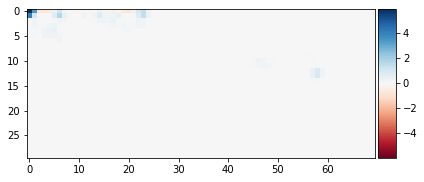

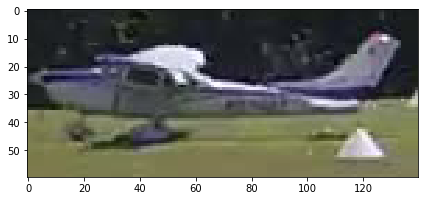

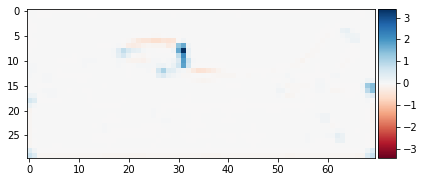

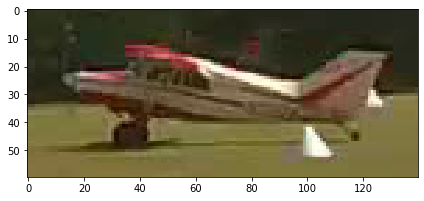

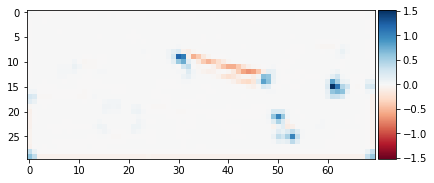

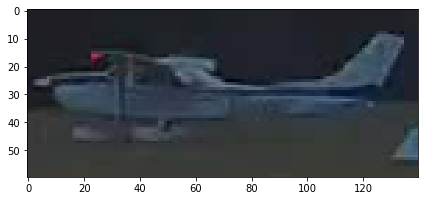

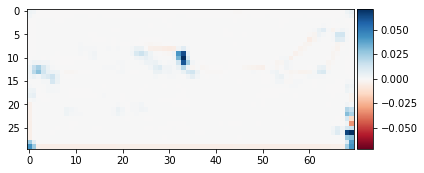

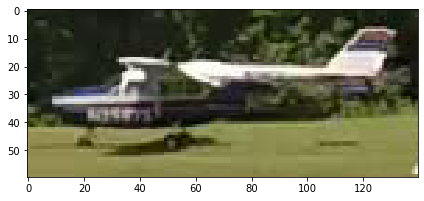

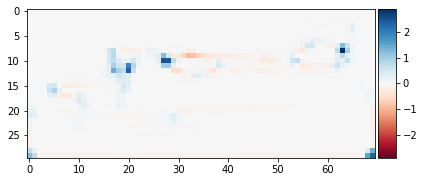

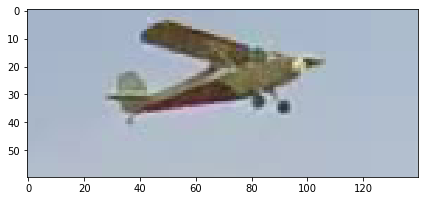

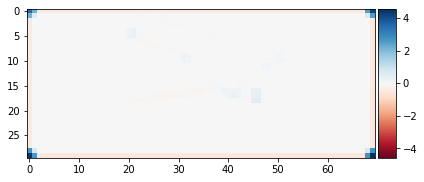

In [202]:
performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [205]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)
final_fits.append(nn5_performance.performance_measures)
final_fits.append(nn5_performance_test.performance_measures)

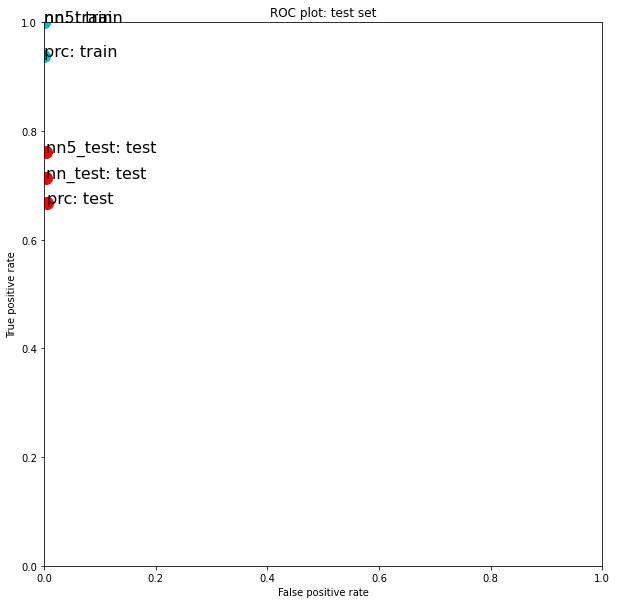

In [206]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# SUBMISSION

### file paths and names:

In [210]:
submission_ci_path = 'test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [211]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 30, 70)
Shape of flat feature representation: 
(1523, 2100)
Shape of X_test for submission:
(1523, 2100)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


### IMPORTANT CHECK: make sure that the number of columns in your training data is the same as the number of columns in this test submission!

In [212]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 2100)
(1523, 2100)


Both the training set and submission test set have 525 columns. Success!

---

Choose a *single* model for your submission. In this code, I am choosing the Perceptron model fit, which is in the prc object. But you should choose the model that is performing the best for you!

In [213]:
# concatenate predictions to the id
X_test_submission["prediction"] = nn5.predict(X_test_data)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

0.014445173998686802


This is the proportion of predictions that have predicted that there is an airplane in the image.

In [214]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


In [215]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('juliet_FINALairplane_submission2.csv', index=False)